# Output Analysis

This notebook contains our analysis of the recommender evaluation results.

It proceeds in a few steps:

1. [Setup](#Setup), where we do the initial R configuration
2. [Read Data](#Read-Data), where we load in the experiment data for analysis
3. [Controlling for Profile Size](#Controlling-for-Profile-Size), where we model accuracy as a function of user profile size in order to control for intrinsic profile difficulty
4. [Gender](#Gender), where we analyze the results by gender.
5. [Age](#Age), where we analyze the results by age.

## Setup

Libraries:

In [1]:
library(MASS)
library(plyr)
library(dplyr)
library(readr)
library(ggplot2)
library(tidyr)
library(modelr)
library(tibble)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Options:

In [2]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)
options(repr.matrix.max.columns=10)

## Read Data

First, we need to read the user data from the underlying MovieLens data:

In [3]:
users.meta = read_delim("data/ml-1m/users.dat", delim=":",
                   col_names=c("user", "gender", "age", "occupation", "zip"),
                   col_types="i_c_c_c_c") %>%
    mutate(gender=as.factor(gender),
           age=as.factor(age),
           occupation=as.factor(occupation))
users.meta

user,gender,age,occupation,zip
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455
⋮,⋮,⋮,⋮,⋮
6036,F,25,15,32603
6037,F,45,1,76006
6038,F,56,1,14706
6039,F,45,0,01060


Now, we want to get user profile statistics. In order to do that, we need each user's train profile; we can load that from the training data output by the cross-folding process.

For each partition, we need to load the _train ratings_ (historical profile) for all the _test users_ in that partition. So we will load the test data (to get the users) and the train data (to get the histories), then merge them.

train ratings for gender balanced dataset

In [4]:
train.ratings = ldply(1:5, function(part) {
    message("reading part ", part)
    test.fn = sprintf("build/ML-1M.out/part0%d.test.csv", part)
    train.fn = sprintf("build/ML-1M.out/part0%d.train.csv", part)
    test = suppressMessages(read_csv(test.fn, col_names=c("user", "item", "rating", "timestamp")))
    train = suppressMessages(read_csv(train.fn, col_names=c("user", "item", "rating", "timestamp")))
    test %>%
        select(user) %>%
        distinct() %>%
        mutate(part=as.factor(part), proto=as.factor('UserPct')) %>%
        inner_join(train)
})

reading part 1
Joining, by = "user"
reading part 2
Joining, by = "user"
reading part 3
Joining, by = "user"
reading part 4
Joining, by = "user"
reading part 5
Joining, by = "user"


In [5]:
train.ratings.GB = ldply(1:5, function(part) {
    message("reading part ", part)
    test.fn = sprintf("build/ML-1M.GB.out/part0%d.test.csv", part)
    train.fn = sprintf("build/ML-1M.GB.out/part0%d.train.csv", part)
    test = suppressMessages(read_csv(test.fn, col_names=c("user", "item", "rating", "timestamp")))
    train = suppressMessages(read_csv(train.fn, col_names=c("user", "item", "rating", "timestamp")))
    test %>%
        select(user) %>%
        distinct() %>%
        mutate(part=as.factor(part), proto=as.factor('UserPct')) %>%
        inner_join(train)
})

reading part 1
Joining, by = "user"
reading part 2
Joining, by = "user"
reading part 3
Joining, by = "user"
reading part 4
Joining, by = "user"
reading part 5
Joining, by = "user"


Quick summary just to see what this data looks like:

In [6]:
train.ratings %>%
    select(part, proto, rating) %>%
    summary()

 part           proto            rating     
 1:200413   UserPct:970009   Min.   :1.000  
 2:204820                    1st Qu.:3.000  
 3:185240                    Median :4.000  
 4:191357                    Mean   :3.578  
 5:188179                    3rd Qu.:4.000  
                             Max.   :5.000  

In [8]:
train.ratings.GB %>%
    select(part, proto, rating) %>%
    summary()

 part          proto            rating     
 1:95437   UserPct:467800   Min.   :1.000  
 2:91091                    1st Qu.:3.000  
 3:89855                    Median :4.000  
 4:93128                    Mean   :3.596  
 5:98289                    3rd Qu.:4.000  
                            Max.   :5.000  

Now we want to compute per-user profile statistics:

In [9]:
user.stats = train.ratings %>%
    group_by(user) %>%
    summarize(nratings = n(), meanRating=mean(rating), ratingVar=var(rating))
user.stats

user,nratings,meanRating,ratingVar
1,48,4.166667,0.4822695
2,124,3.717742,1.0009835
3,46,3.869565,0.9159420
4,16,4.062500,1.2625000
5,193,3.129534,1.2904253
⋮,⋮,⋮,⋮
6036,883,3.305776,1.0492523
6037,197,3.725888,0.7816223
6038,15,4.200000,0.6000000
6039,118,3.872881,0.5221643


In [11]:
user.stats.GB = train.ratings.GB %>%
    group_by(user) %>%
    summarize(nratings = n(), meanRating=mean(rating), ratingVar=var(rating))
user.stats.GB

user,nratings,meanRating,ratingVar
1,48,4.145833,0.4676418
2,124,3.677419,1.0007868
5,193,3.134715,1.2838407
6,66,3.893939,0.7116550
8,134,3.888060,0.8670744
⋮,⋮,⋮,⋮
6033,55,3.854545,0.8303030
6035,275,2.603636,2.2693298
6036,883,3.301246,1.0520052
6038,15,3.800000,1.6000000


Join these statistics with our user metadata table, so that we have one table of user information:

In [12]:
users = users.meta %>% inner_join(user.stats)
users

Joining, by = "user"


user,gender,age,occupation,zip,nratings,meanRating,ratingVar
1,F,1,10,48067,48,4.166667,0.4822695
2,M,56,16,70072,124,3.717742,1.0009835
3,M,25,15,55117,46,3.869565,0.9159420
4,M,45,7,02460,16,4.062500,1.2625000
5,M,25,20,55455,193,3.129534,1.2904253
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6036,F,25,15,32603,883,3.305776,1.0492523
6037,F,45,1,76006,197,3.725888,0.7816223
6038,F,56,1,14706,15,4.200000,0.6000000
6039,F,45,0,01060,118,3.872881,0.5221643


In [13]:
users.GB = users.meta %>% inner_join(user.stats.GB)
users.GB

Joining, by = "user"


user,gender,age,occupation,zip,nratings,meanRating,ratingVar
1,F,1,10,48067,48,4.145833,0.4676418
2,M,56,16,70072,124,3.677419,1.0007868
5,M,25,20,55455,193,3.134715,1.2838407
6,F,50,9,55117,66,3.893939,0.7116550
8,M,25,12,11413,134,3.888060,0.8670744
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6033,M,50,13,78232,55,3.854545,0.8303030
6035,F,25,1,78734,275,2.603636,2.2693298
6036,F,25,15,32603,883,3.301246,1.0520052
6038,F,56,1,14706,15,3.800000,1.6000000


Now that we have user information, we can read the per-user recommender evaluation results.

In [14]:
user.results.all = read_csv("build/movielens-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    mutate(DataSet=as.factor(DataSet), 
           Partition=as.factor(Partition),
           Algorithm=as.factor(Algorithm)) %>%
    inner_join(users)
head(user.results.all)

Parsed with column specification:
cols(
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  TestTime = col_double(),
  RMSE = col_double(),
  Rank.nDCG = col_double(),
  nDCG = col_double(),
  Rank = col_integer(),
  RecipRank = col_double(),
  AvgPrec = col_double(),
  `1R.nDCG` = col_character(),
  `1R.Rank` = col_character(),
  `1R.RecipRank` = col_character(),
  `1R.AvgPrec` = col_character()
)
Joining, by = "user"


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,nDCG,Rank,RecipRank,⋯,1R.Rank,1R.RecipRank,1R.AvgPrec,gender,age,occupation,zip,nratings,meanRating,ratingVar
ML-1M.UI,4,Pop-B,4040,0.014,NA,1,0,NA,0,⋯,NA,NA,NA,M,25,20,75006,181,2.972376,1.4492327
ML-1M.UI,4,Pop-B,4041,0.007,NA,1,0,NA,0,⋯,NA,NA,NA,M,18,3,48005,839,3.313468,1.0340785
ML-1M.UI,3,Pop-B,4084,0.004,NA,1,0,NA,0,⋯,NA,NA,NA,M,56,13,14215,163,4.343558,0.5725971
ML-1M.UI,4,Pop-B,4042,0.005,NA,1,0,NA,0,⋯,NA,NA,NA,M,35,15,94002,441,3.349206,0.8868687
ML-1M.UI,3,Pop-B,4085,0.004,NA,1,0,NA,0,⋯,NA,NA,NA,F,25,6,79416,824,3.610437,0.7216892
ML-1M.UI,4,Pop-B,4045,0.003,NA,1,0,NA,0,⋯,NA,NA,NA,M,56,13,40511,39,3.538462,1.3603239


In [15]:
user.results.all.GB = read_csv("build/movielens-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    mutate(DataSet=as.factor(DataSet), 
           Partition=as.factor(Partition),
           Algorithm=as.factor(Algorithm)) %>%
    inner_join(users.GB)
head(user.results.all.GB)

Parsed with column specification:
cols(
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  TestTime = col_double(),
  RMSE = col_double(),
  Rank.nDCG = col_double(),
  nDCG = col_double(),
  Rank = col_integer(),
  RecipRank = col_double(),
  AvgPrec = col_double(),
  `1R.nDCG` = col_character(),
  `1R.Rank` = col_character(),
  `1R.RecipRank` = col_character(),
  `1R.AvgPrec` = col_character()
)
Joining, by = "user"


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,nDCG,Rank,RecipRank,⋯,1R.Rank,1R.RecipRank,1R.AvgPrec,gender,age,occupation,zip,nratings,meanRating,ratingVar
ML-1M.UI,3,Pop-B,4085,0.004,NA,1.0000000,0,NA,0,⋯,NA,NA,NA,F,25,6,79416,824,3.608010,0.7197900
ML-1M.UI,4,Pop-B,4045,0.003,NA,1.0000000,0,NA,0,⋯,NA,NA,NA,M,56,13,40511,39,3.410256,1.3009447
ML-1M.UI,3,Pop-B,4086,0.004,NA,1.0000000,0,NA,0,⋯,NA,NA,NA,F,1,10,55391,313,4.498403,0.8213115
ML-1M.UI,4,Pop-B,4048,0.054,NA,0.8336621,0,NA,0,⋯,NA,NA,NA,F,35,1,89431,724,3.752762,1.1877517
ML-1M.UI,3,Pop-B,4088,0.052,NA,0.9379338,0,NA,0,⋯,NA,NA,NA,M,25,3,77057,398,3.286432,1.3837449
ML-1M.UI,5,Pop-B,3985,0.030,NA,0.8730898,0,NA,0,⋯,NA,NA,NA,M,45,16,01880,326,3.585890,0.8095234


We will often want to use the standard-crossfold user results, so filter those down into a table:

In [17]:
user.results = user.results.all %>%
    filter(DataSet == 'ML-1M')

In [18]:
user.results.GB = user.results.all.GB %>%
    filter(DataSet == 'ML-1M.GB')

## Controlling for Profile Size

Users with more ratings are easier to predict for; we want to be able to remove that effect. We will focus for now on nDCG.

There are two ways we can try to model: we can consider all algorithms, and just try to predict based on e.g. nratings. The other is that we can aggregate by user to produce a per-user 'difficulty' score. We will do the latter to avoid statistical non-independence problems.

In [28]:
user.ndcg = user.results %>%
    group_by(DataSet,user) %>%
    summarize(nDCG=mean(nDCG)) %>%
    inner_join(users)
user.ndcg

Joining, by = "user"


DataSet,user,nDCG,gender,age,occupation,zip,nratings,meanRating,ratingVar
ML-1M,1,0.06989775,F,1,10,48067,48,4.166667,0.4822695
ML-1M,2,0.11697961,M,56,16,70072,124,3.717742,1.0009835
ML-1M,3,0.07831893,M,25,15,55117,46,3.869565,0.9159420
ML-1M,4,0.23729804,M,45,7,02460,16,4.062500,1.2625000
ML-1M,5,0.02850559,M,25,20,55455,193,3.129534,1.2904253
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML-1M,6036,0.07948750,F,25,15,32603,883,3.305776,1.0492523
ML-1M,6037,0.14921764,F,45,1,76006,197,3.725888,0.7816223
ML-1M,6038,0.05864530,F,56,1,14706,15,4.200000,0.6000000
ML-1M,6039,0.07193646,F,45,0,01060,118,3.872881,0.5221643


In [29]:
user.ndcg.GB = user.results.GB %>%
    group_by(DataSet,user) %>%
    summarize(nDCG=mean(nDCG)) %>%
    inner_join(users.GB)
user.ndcg.GB

Joining, by = "user"


DataSet,user,nDCG,gender,age,occupation,zip,nratings,meanRating,ratingVar
ML-1M.GB,1,0.11176864,F,1,10,48067,48,4.145833,0.4676418
ML-1M.GB,2,0.09800798,M,56,16,70072,124,3.677419,1.0007868
ML-1M.GB,5,0.05316293,M,25,20,55455,193,3.134715,1.2838407
ML-1M.GB,6,0.05678314,F,50,9,55117,66,3.893939,0.7116550
ML-1M.GB,8,0.09766036,M,25,12,11413,134,3.888060,0.8670744
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML-1M.GB,6033,0.086787046,M,50,13,78232,55,3.854545,0.8303030
ML-1M.GB,6035,0.002189029,F,25,1,78734,275,2.603636,2.2693298
ML-1M.GB,6036,0.024127288,F,25,15,32603,883,3.301246,1.0520052
ML-1M.GB,6038,0.053243537,F,56,1,14706,15,3.800000,1.6000000


Let's plot to see what this is looking like:

In [30]:
combined.user.ndcg = rbind(user.ndcg, user.ndcg.GB)

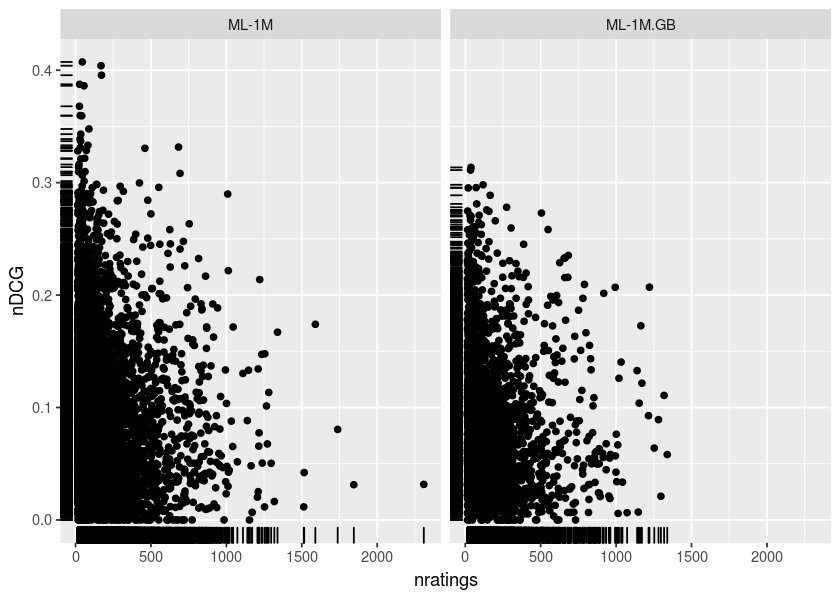

In [32]:
ggplot(combined.user.ndcg) +
    aes(x=nratings, y=nDCG) +
    geom_point() + 
    geom_rug() +
    facet_wrap(~DataSet, scales="fixed")

Oof, that distribution is concentrated. Let's log the number of ratings, since log is often a good transform for counts:

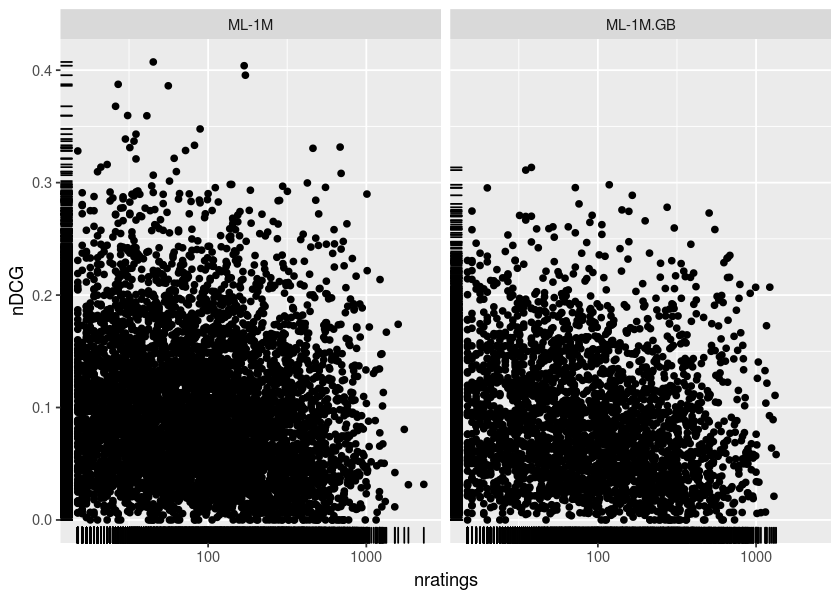

In [33]:
ggplot(combined.user.ndcg) +
    aes(x=nratings, y=nDCG) +
    geom_point() + 
    geom_rug() +
    scale_x_log10() +
    facet_wrap(~DataSet, scales="fixed")

Looking better. Let's see how the difficulty (nDCG) is distributed (Q-Q plot):

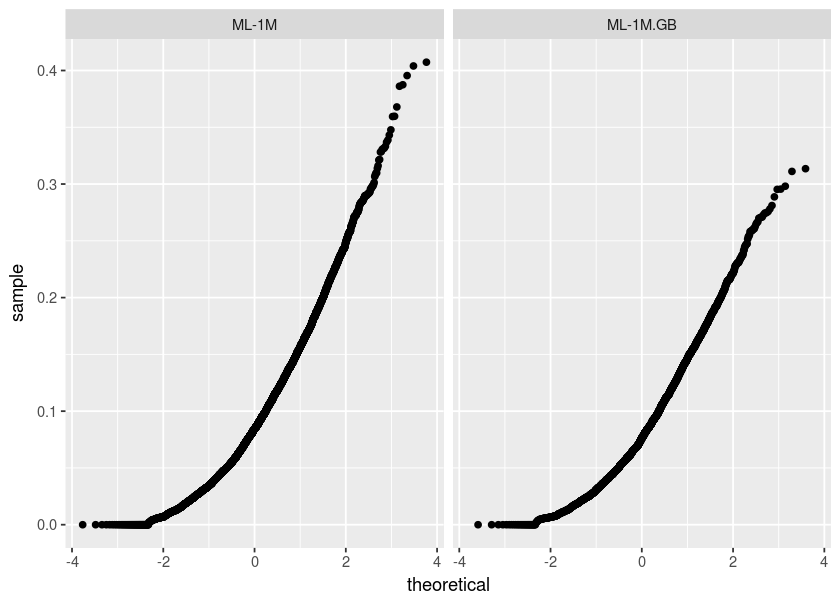

In [34]:
ggplot(combined.user.ndcg) +
    aes(sample=nDCG) +
    geom_qq()+
    facet_wrap(~DataSet, scales="fixed")

That isn't quite normal; however, a log transform looks like it will be too aggressive. Let's try a square root:

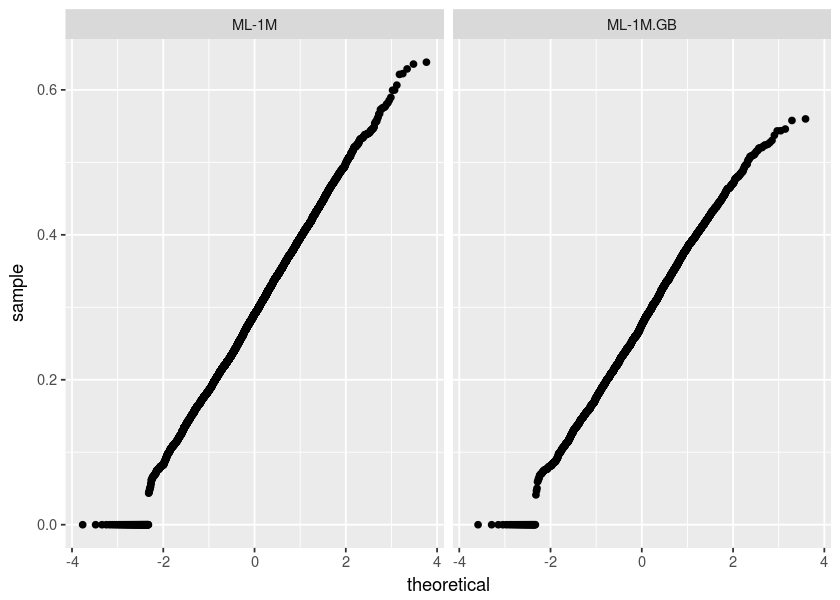

In [35]:
ggplot(combined.user.ndcg) +
    aes(sample=sqrt(nDCG)) +
    geom_qq() +
    facet_wrap(~DataSet, scales="fixed")

That looks close to normal.

Let's use log10 of the nratings as our predictor, and square root of nDCG as our dependent variable. But we will try more basic models too so we can see the improvement.

In [36]:
user.ndcg.mod.raw = lm(nDCG ~ nratings, data=user.ndcg)
summary(user.ndcg.mod.raw)


Call:
lm(formula = nDCG ~ nratings, data = user.ndcg)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.10088 -0.04715 -0.01127  0.03504  0.30909 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.016e-01  1.036e-03  98.017   <2e-16 ***
nratings    -3.976e-05  4.131e-06  -9.624   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06188 on 6038 degrees of freedom
Multiple R-squared:  0.01511,	Adjusted R-squared:  0.01495 
F-statistic: 92.63 on 1 and 6038 DF,  p-value: < 2.2e-16


In [37]:
user.ndcg.mod.raw.GB = lm(nDCG ~ nratings, data=user.ndcg.GB)
summary(user.ndcg.mod.raw.GB)


Call:
lm(formula = nDCG ~ nratings, data = user.ndcg.GB)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09135 -0.04332 -0.01039  0.03355  0.22290 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.184e-02  1.338e-03  68.634  < 2e-16 ***
nratings    -3.225e-05  5.486e-06  -5.878  4.6e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05635 on 2998 degrees of freedom
Multiple R-squared:  0.01139,	Adjusted R-squared:  0.01106 
F-statistic: 34.55 on 1 and 2998 DF,  p-value: 4.602e-09


In [38]:
user.ndcg.mod.log = lm(nDCG ~ log10(nratings), data=user.ndcg)
summary(user.ndcg.mod.log)


Call:
lm(formula = nDCG ~ log10(nratings), data = user.ndcg)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.11017 -0.04655 -0.01091  0.03416  0.31432 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.136646   0.003485   39.21   <2e-16 ***
log10(nratings) -0.021095   0.001727  -12.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0616 on 6038 degrees of freedom
Multiple R-squared:  0.0241,	Adjusted R-squared:  0.02394 
F-statistic: 149.1 on 1 and 6038 DF,  p-value: < 2.2e-16


In [39]:
user.ndcg.mod.log.GB = lm(nDCG ~ log10(nratings), data=user.ndcg.GB)
summary(user.ndcg.mod.log.GB)


Call:
lm(formula = nDCG ~ log10(nratings), data = user.ndcg.GB)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.101297 -0.042961 -0.009985  0.033563  0.219781 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.123340   0.004458   27.67   <2e-16 ***
log10(nratings) -0.018742   0.002226   -8.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05602 on 2998 degrees of freedom
Multiple R-squared:  0.0231,	Adjusted R-squared:  0.02278 
F-statistic: 70.89 on 1 and 2998 DF,  p-value: < 2.2e-16


In [40]:
user.ndcg.mod = lm(sqrt(nDCG) ~ log10(nratings), data=user.ndcg)
summary(user.ndcg.mod)


Call:
lm(formula = sqrt(nDCG) ~ log10(nratings), data = user.ndcg)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31819 -0.07065 -0.00061  0.06854  0.35549 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.367368   0.005811   63.22   <2e-16 ***
log10(nratings) -0.039176   0.002880  -13.60   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1027 on 6038 degrees of freedom
Multiple R-squared:  0.02973,	Adjusted R-squared:  0.02957 
F-statistic:   185 on 1 and 6038 DF,  p-value: < 2.2e-16


In [41]:
user.ndcg.mod.GB = lm(sqrt(nDCG) ~ log10(nratings), data=user.ndcg.GB)
summary(user.ndcg.mod.GB)


Call:
lm(formula = sqrt(nDCG) ~ log10(nratings), data = user.ndcg.GB)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.305991 -0.068703 -0.000281  0.068881  0.273611 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.350010   0.007861  44.526   <2e-16 ***
log10(nratings) -0.037428   0.003925  -9.535   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09879 on 2998 degrees of freedom
Multiple R-squared:  0.02943,	Adjusted R-squared:  0.02911 
F-statistic: 90.92 on 1 and 2998 DF,  p-value: < 2.2e-16


This is the best model. Let's fill in our data with it. We compute residuals manually, because we linear model residuals are in square-root space. For checking the model, we want:

$$\epsilon_i = \sqrt{\mathrm{nDCG}}-y_i$$

However, we also do want the _error_, which is

$$e_i = \mathrm{nDCG} - y_i^2$$

In [42]:
user.ndcg.preds = user.ndcg %>%
    add_predictions(user.ndcg.mod) %>%
    rename(predRoot=pred) %>%
    mutate(pred = predRoot * predRoot, resid=sqrt(nDCG) - predRoot, error=nDCG-pred)
head(user.ndcg.preds)

DataSet,user,nDCG,gender,age,occupation,zip,nratings,meanRating,ratingVar,predRoot,pred,resid,error
ML-1M,1,0.06989775,F,1,10,48067,48,4.166667,0.4822695,0.3015034,0.09090427,-0.03712153,-0.02100652
ML-1M,2,0.11697961,M,56,16,70072,124,3.717742,1.0009835,0.2853557,0.08142789,0.05666708,0.03555171
ML-1M,3,0.07831893,M,25,15,55117,46,3.869565,0.9159420,0.3022275,0.09134144,-0.02237227,-0.01302251
ML-1M,4,0.23729804,M,45,7,02460,16,4.062500,1.2625000,0.3201951,0.10252491,0.16693736,0.13477313
ML-1M,5,0.02850559,M,25,20,55455,193,3.129534,1.2904253,0.2778286,0.07718873,-0.10899262,-0.04868314
ML-1M,6,0.07227690,F,50,9,55117,66,3.909091,0.6685315,0.2960852,0.08766644,-0.02724156,-0.01538954


In [43]:
user.ndcg.preds.GB = user.ndcg.GB %>%
    add_predictions(user.ndcg.mod.GB) %>%
    rename(predRoot=pred) %>%
    mutate(pred = predRoot * predRoot, resid=sqrt(nDCG) - predRoot, error=nDCG-pred)
head(user.ndcg.preds.GB)

DataSet,user,nDCG,gender,age,occupation,zip,nratings,meanRating,ratingVar,predRoot,pred,resid,error
ML-1M.GB,1,0.11176864,F,1,10,48067,48,4.145833,0.4676418,0.2870840,0.08241725,0.04723414,0.02935140
ML-1M.GB,2,0.09800798,M,56,16,70072,124,3.677419,1.0007868,0.2716568,0.07379744,0.04140542,0.02421054
ML-1M.GB,5,0.05316293,M,25,20,55455,193,3.134715,1.2838407,0.2644655,0.06994202,-0.03389467,-0.01677909
ML-1M.GB,6,0.05678314,F,50,9,55117,66,3.893939,0.7116550,0.2819076,0.07947190,-0.04361549,-0.02268877
ML-1M.GB,8,0.09766036,M,25,12,11413,134,3.888060,0.8670744,0.2703961,0.07311408,0.04211043,0.02454628
ML-1M.GB,9,0.10953497,M,25,17,61614,101,3.693069,0.6548515,0.2749917,0.07562044,0.05596897,0.03391453


In [44]:
combined.user.ndcg.preds = rbind(user.ndcg.preds, user.ndcg.preds.GB)

`geom_smooth()` using method = 'gam'


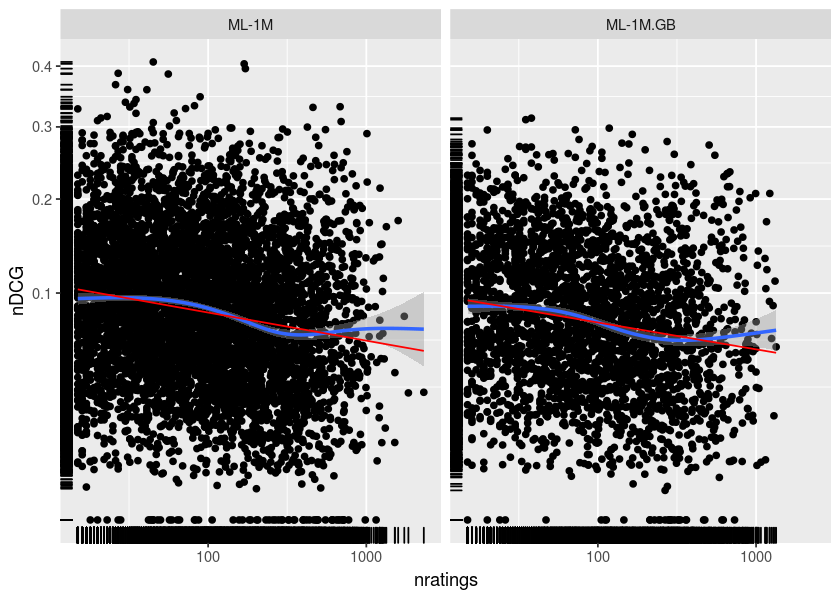

In [45]:
ggplot(combined.user.ndcg.preds) +
    aes(x=nratings, y=nDCG) +
    geom_point() + 
    geom_smooth() +
    geom_line(mapping=aes(y=pred), color="red") +
    geom_rug() +
    scale_x_log10() + scale_y_sqrt() +
    facet_wrap(~DataSet, scales="fixed")

We will be good citizens and plot our residuals.

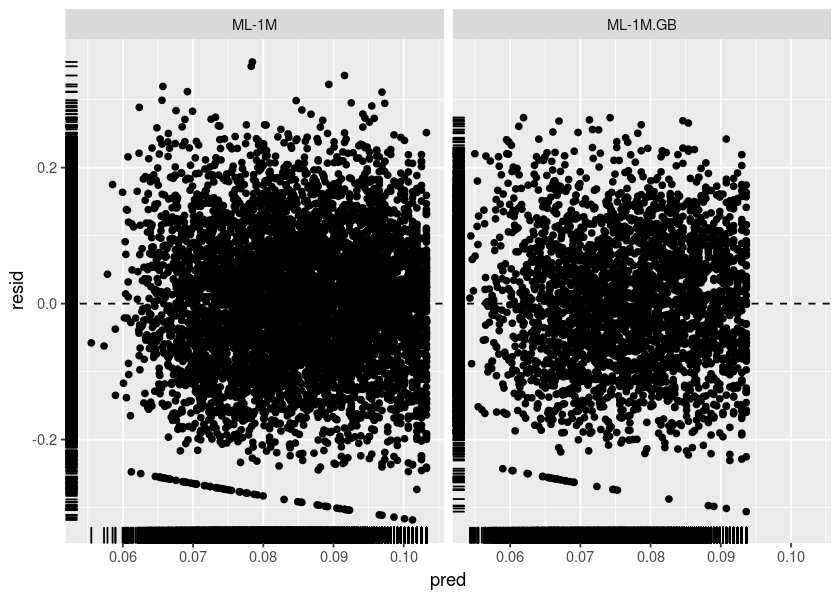

In [48]:
ggplot(combined.user.ndcg.preds) +
    aes(x=pred, y=resid) +
    geom_point() +
    geom_rug() +
    geom_hline(yintercept=0, linetype="dashed") +
    facet_wrap(~DataSet, scales="fixed")

That is mostly noise with the exception of that one line at the bottom; but our initial plot of outcome variable distribution suggested there's a chunk of 0 values that will cause funny business.

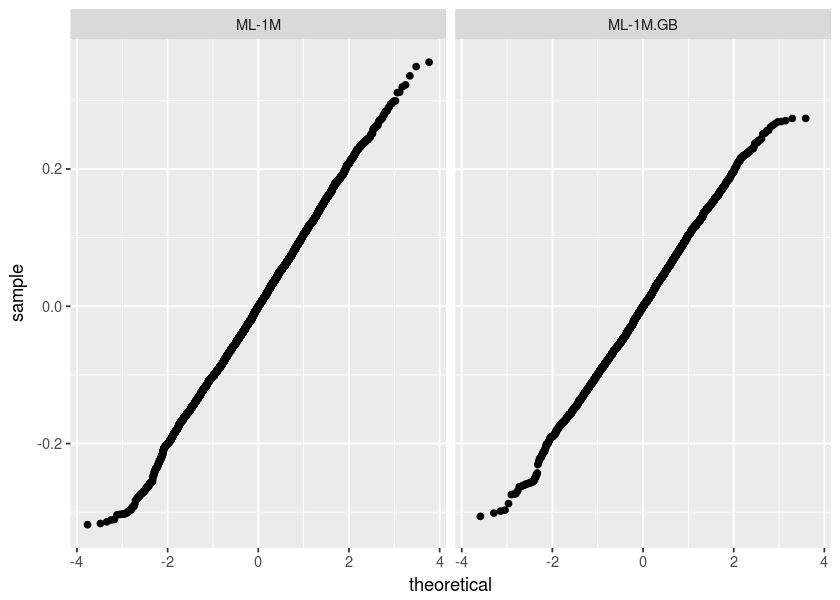

In [49]:
ggplot(combined.user.ndcg.preds) +
    aes(sample=resid) +
    geom_qq() +
    facet_wrap(~DataSet, scales="fixed")

Not bad! We don't need this, since we are not looking for an inferentially-valid linear model. But it is a good idea to check anyway.

## Gender

Let's analyze accuracy by gender.

In [50]:
combined.user.results = rbind(user.results, user.results.GB)

In [51]:
# FIXME re-add rank.ndcg
gender.results = combined.user.results %>%
    select(DataSet, Algorithm, gender, MAP=AvgPrec, MRR=RecipRank, RMSE, nDCG) %>%
    gather("Metric", "value", -DataSet, -Algorithm, -gender) %>%
    group_by(DataSet, Algorithm, gender, Metric) %>%
    summarize(value=mean(value, na.rm=TRUE)) %>%
    ungroup()
head(gender.results)

DataSet,Algorithm,gender,Metric,value
ML-1M,II-B,F,MAP,0.1419534
ML-1M,II-B,F,MRR,0.2083475
ML-1M,II-B,F,nDCG,0.1640384
ML-1M,II-B,F,RMSE,NaN
ML-1M,II-B,M,MAP,0.1681144
ML-1M,II-B,M,MRR,0.2602812


In [52]:
overall.results = combined.user.results %>%
    select(DataSet, Algorithm, MAP=AvgPrec, MRR=RecipRank, RMSE, nDCG) %>%
    gather("Metric", "value", -DataSet, -Algorithm) %>%
    group_by(DataSet, Algorithm, Metric) %>%
    summarize(value=mean(value, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(gender = 'Any')
combined.results = rbind(gender.results, overall.results)
head(combined.results)

DataSet,Algorithm,gender,Metric,value
ML-1M,II-B,F,MAP,0.1419534
ML-1M,II-B,F,MRR,0.2083475
ML-1M,II-B,F,nDCG,0.1640384
ML-1M,II-B,F,RMSE,NaN
ML-1M,II-B,M,MAP,0.1681144
ML-1M,II-B,M,MRR,0.2602812


In [53]:
options(repr.plot.height=10)

Warning message:
“Removed 24 rows containing missing values (geom_bar).”

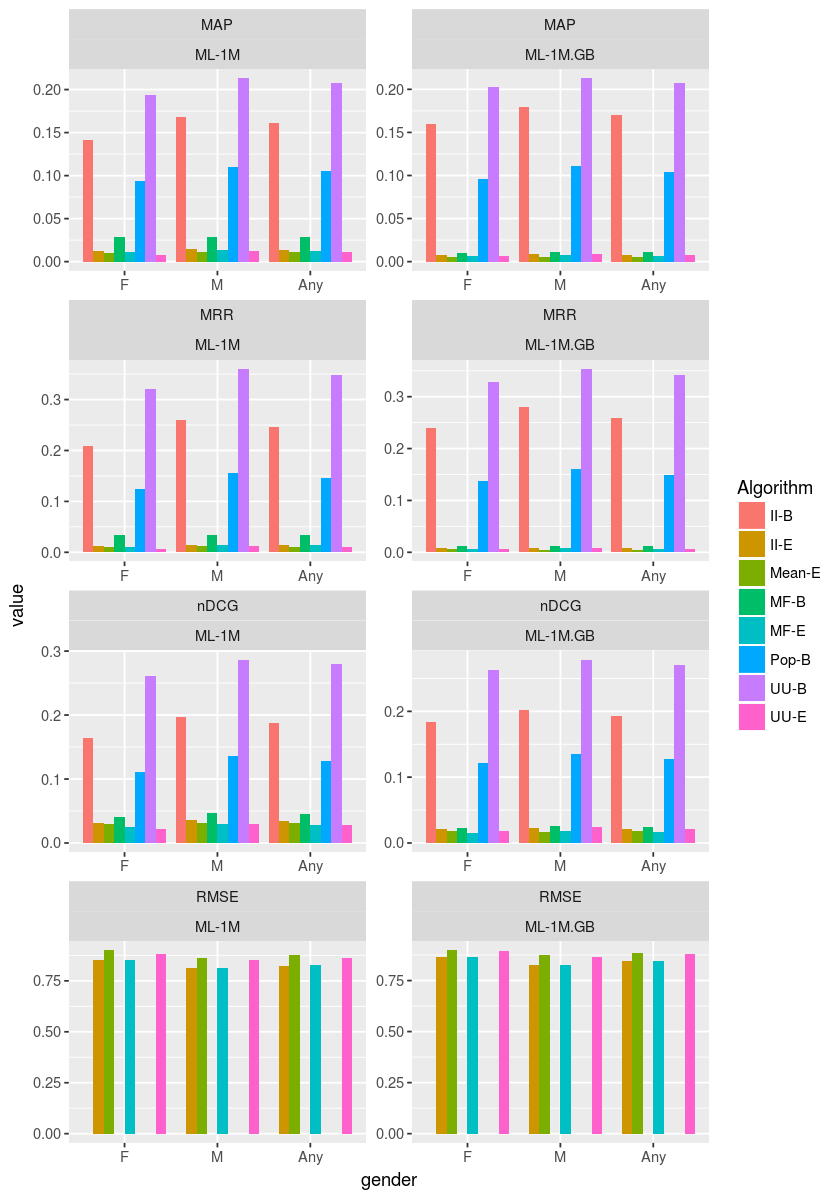

In [54]:
ggplot(combined.results) +
    aes(x=gender, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_wrap(c('Metric', 'DataSet'), nrow = 4, ncol = 2, scales="free")

### Controlled Effects

Now we want to control for the size of user's profile. Since male users rate more movies than female users, and long profiles are easier to predict for, it is possible that the increase in improvement for male users is due to rating size.

We will control for that by using our linear model for predicting 'difficulty' using profile size, and look at the remaining effect of gender on accuracy.

In [56]:
gender.corr.ndcg = user.results %>%
    select(DataSet, user, Algorithm, gender, nDCG) %>%
    inner_join(select(user.ndcg.preds, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG) %>%
    group_by(DataSet, gender, Algorithm) %>%
    summarize(nDCG=mean(nDCG), Corr.nDCG=mean(Corr.nDCG))
head(gender.corr.ndcg)

Adding missing grouping variables: `DataSet`
Joining, by = c("DataSet", "user")


DataSet,gender,Algorithm,nDCG,Corr.nDCG
ML-1M,F,II-B,0.16403841,0.07803448
ML-1M,F,II-E,0.03073581,-0.05526813
ML-1M,F,Mean-E,0.02891874,-0.05708519
ML-1M,F,MF-B,0.04080738,-0.04519655
ML-1M,F,MF-E,0.02541279,-0.06059115
ML-1M,F,Pop-B,0.11031017,0.02430623


In [58]:
gender.corr.ndcg.GB = user.results.GB %>%
    select(DataSet, user, Algorithm, gender, nDCG) %>%
    inner_join(select(user.ndcg.preds.GB, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG) %>%
    group_by(DataSet,gender, Algorithm) %>%
    summarize(nDCG=mean(nDCG), Corr.nDCG=mean(Corr.nDCG))
head(gender.corr.ndcg.GB)

Adding missing grouping variables: `DataSet`
Joining, by = c("DataSet", "user")


DataSet,gender,Algorithm,nDCG,Corr.nDCG
ML-1M.GB,F,II-B,0.18407905,0.10601009
ML-1M.GB,F,II-E,0.02095204,-0.05711691
ML-1M.GB,F,Mean-E,0.01870500,-0.05936395
ML-1M.GB,F,MF-B,0.02271262,-0.05535633
ML-1M.GB,F,MF-E,0.01552528,-0.06254367
ML-1M.GB,F,Pop-B,0.12102987,0.04296092


In [59]:
combined.gender.corr.ndcg = rbind(gender.corr.ndcg, gender.corr.ndcg.GB)

In [82]:
options(repr.plot.height=5)
options(repr.plot.width=10)

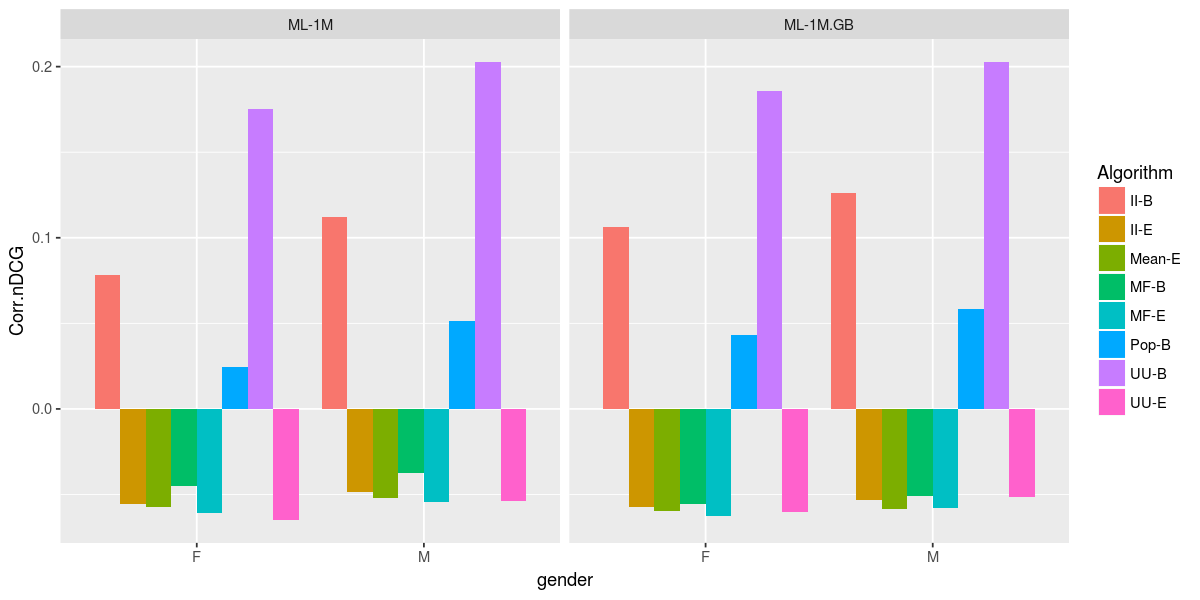

In [83]:
ggplot(combined.gender.corr.ndcg) +
    aes(x=gender, y=Corr.nDCG, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_wrap(~DataSet,scales="fixed")

After controlling for the number of ratings, we still see increased accuracy for male users. 

<!-- _Even_ for the demographic popularity recommenders! -->

### Weird Gender Control Analysis

Michael tried this control for gender effects, but it was kinda weird and doesn't tell us anything meaningful, we think. So ignore it (but the code is still here for history).

In [67]:
gender.effects = user.results %>%
    select(gender, MAP=AvgPrec, MRR=RecipRank, RMSE, nDCG) %>%
    gather("Metric", "value", -gender) %>%
    group_by(gender, Metric) %>%
    summarize(effect=mean(value, na.rm=TRUE)) %>%
    ungroup()
gender.effects

gender,Metric,effect
F,MAP,0.06238588
F,MRR,0.09123809
F,nDCG,0.08535692
F,RMSE,0.87270356
M,MAP,0.07148080
M,MRR,0.10790586
M,nDCG,0.09909122
M,RMSE,0.83626384


In [68]:
gender.effects.GB = user.results.GB %>%
    select(gender, MAP=AvgPrec, MRR=RecipRank, RMSE, nDCG) %>%
    gather("Metric", "value", -gender) %>%
    group_by(gender, Metric) %>%
    summarize(effect=mean(value, na.rm=TRUE)) %>%
    ungroup()
gender.effects.GB

gender,Metric,effect
F,MAP,0.06177285
F,MRR,0.09286087
F,nDCG,0.08308710
F,RMSE,0.88140226
M,MAP,0.06825832
M,MRR,0.10444515
M,nDCG,0.09052697
M,RMSE,0.84842646


In [85]:
controlled.gender.results = user.results %>%
    select(DataSet, Algorithm, gender, MAP=AvgPrec, MRR=RecipRank, RMSE, nDCG) %>%
    gather("Metric", "value", -DataSet, -Algorithm, -gender) %>%
    inner_join(gender.effects) %>%
    mutate(offset = value - effect) %>%
    select(-effect) %>%
    group_by(DataSet, Algorithm, gender, Metric) %>%
    summarize(offset=mean(offset, na.rm=TRUE)) %>%
    ungroup()
head(controlled.gender.results)

Joining, by = c("gender", "Metric")


DataSet,Algorithm,gender,Metric,offset
ML-1M,II-B,F,MAP,0.07956748
ML-1M,II-B,F,MRR,0.11710940
ML-1M,II-B,F,nDCG,0.07868149
ML-1M,II-B,F,RMSE,NaN
ML-1M,II-B,M,MAP,0.09663356
ML-1M,II-B,M,MRR,0.15237530


In [84]:
controlled.gender.results.GB = user.results.GB %>%
    select(DataSet, Algorithm, gender, MAP=AvgPrec, MRR=RecipRank, RMSE, nDCG) %>%
    gather("Metric", "value",-DataSet, -Algorithm, -gender) %>%
    inner_join(gender.effects.GB) %>%
    mutate(offset = value - effect) %>%
    select(-effect) %>%
    group_by(DataSet, Algorithm, gender, Metric) %>%
    summarize(offset=mean(offset, na.rm=TRUE)) %>%
    ungroup()
head(controlled.gender.results.GB)

Joining, by = c("gender", "Metric")


DataSet,Algorithm,gender,Metric,offset
ML-1M.GB,II-B,F,MAP,0.09772216
ML-1M.GB,II-B,F,MRR,0.14680433
ML-1M.GB,II-B,F,nDCG,0.10099195
ML-1M.GB,II-B,F,RMSE,NaN
ML-1M.GB,II-B,M,MAP,0.11159872
ML-1M.GB,II-B,M,MRR,0.17550284


In [86]:
combined.controlled.gender.results = rbind(controlled.gender.results, controlled.gender.results.GB)

In [87]:
options(repr.plot.height=10)
options(repr.plot.width=8)

Warning message:
“Removed 16 rows containing missing values (geom_bar).”

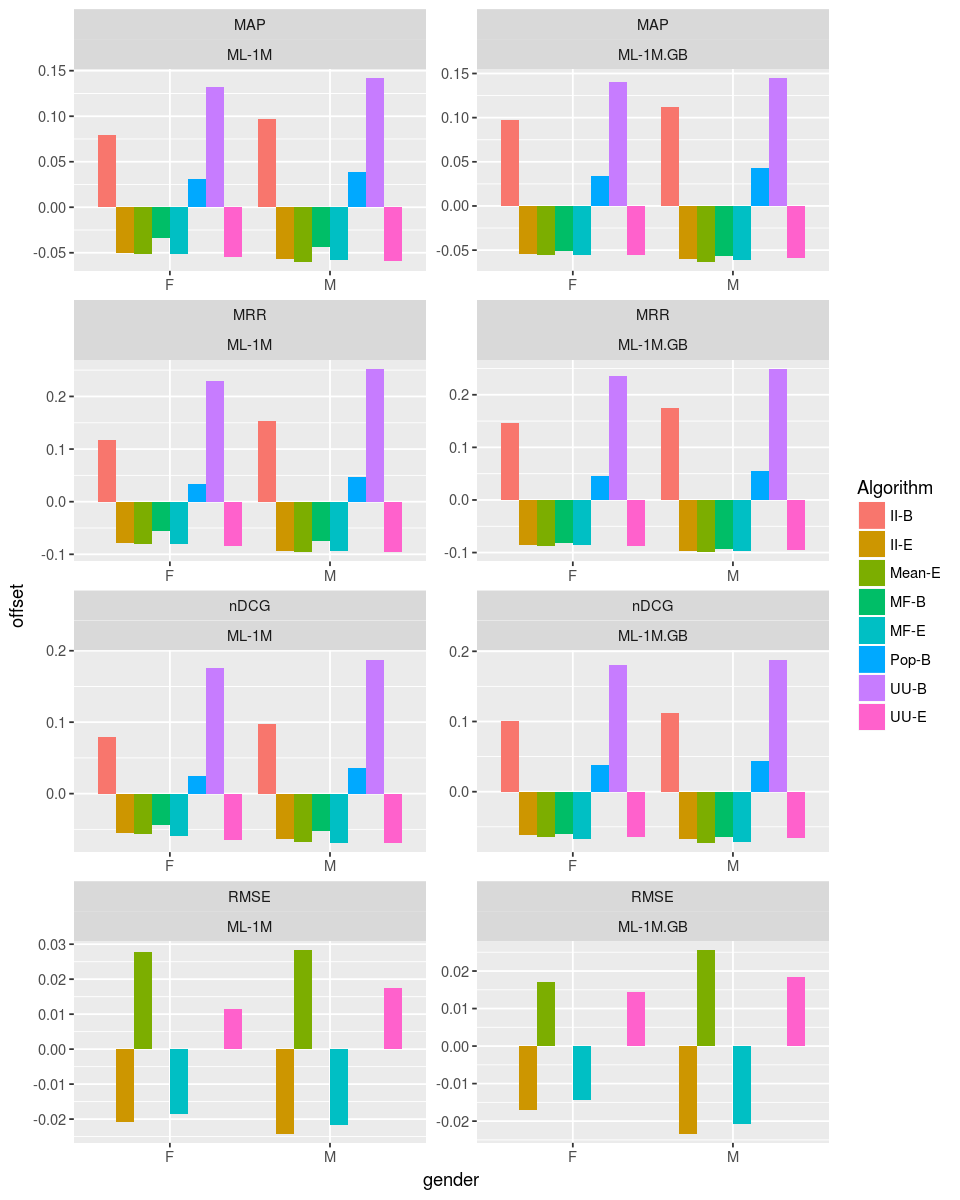

In [88]:
ggplot(combined.controlled.gender.results) +
    aes(x=gender, y=offset, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_wrap(c('Metric', 'DataSet'), nrow = 4, ncol = 2, scales="free")

## Age

We now want to examine accuracy as a function of age. We're basically going to do the same thing we did for gender.

Start by aggregating the results:

In [30]:
# FIXME Re-add rank nDCG
age.results = user.results %>%
    select(Algorithm, age, MAP=AvgPrec, MRR=RecipRank, nDCG) %>%
    gather("Metric", "value", -Algorithm, -age) %>%
    group_by(Algorithm, age, Metric) %>%
    summarize(value=mean(value))
age.results

Algorithm,age,Metric,value
II-B,1,MAP,0.1448092
II-B,1,MRR,0.2267504
II-B,1,nDCG,0.1804995
II-B,18,MAP,0.1654056
II-B,18,MRR,0.2635039
⋮,⋮,⋮,⋮
UU-E,50,MRR,0.007145532
UU-E,50,nDCG,0.022216754
UU-E,56,MAP,0.006705764
UU-E,56,MRR,0.006429232


And then we can plot them:

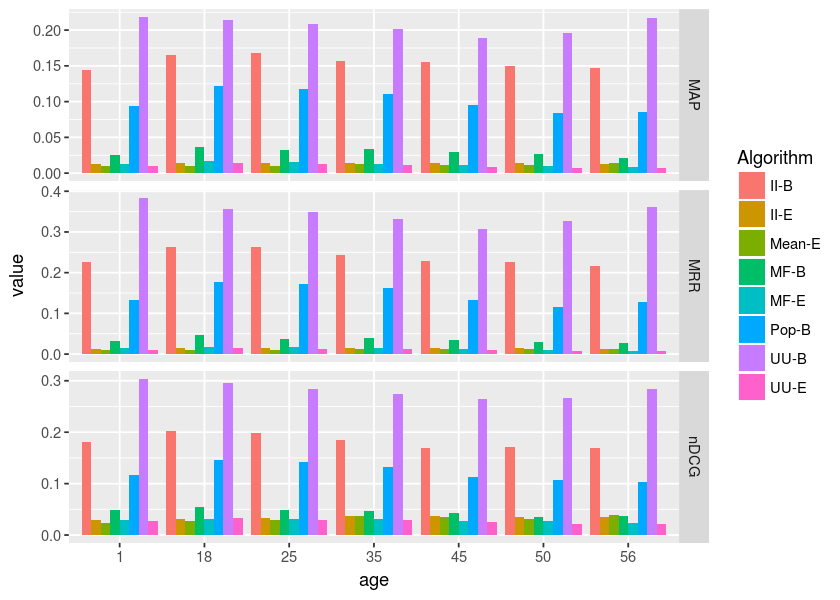

In [31]:
ggplot(age.results) +
    aes(x=age, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_grid(Metric ~ ., scales="free_y")

### Controlling for Profile Size

Let's control for profile size again.

In [32]:
age.corr.ndcg = user.results %>%
    select(user, Algorithm, age, nDCG) %>%
    inner_join(select(user.ndcg.preds, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG) %>%
    group_by(age, Algorithm) %>%
    summarize(nDCG=mean(nDCG), Corr.nDCG=mean(Corr.nDCG))
head(age.corr.ndcg)

Joining, by = "user"


age,Algorithm,nDCG,Corr.nDCG
1,II-B,0.18049953,0.09327252
1,II-E,0.02916638,-0.05806063
1,Mean-E,0.02325226,-0.06397475
1,MF-B,0.04930430,-0.03792271
1,MF-E,0.02870881,-0.05851821
1,Pop-B,0.11716021,0.02993319


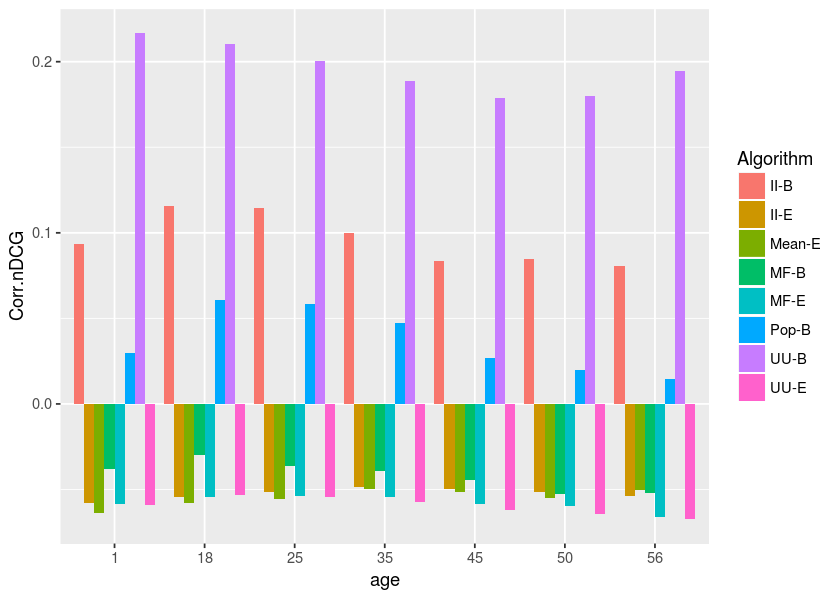

In [33]:
ggplot(age.corr.ndcg) +
    aes(x=age, y=Corr.nDCG, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge")

Discrepancy in performance is robust to controls for size.